# Import Libraries

In [193]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Define Dataset

In [103]:
df = pd.read_csv("breast-cancer_cleaned.csv")
df

,texture_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,-2.073335,2.217515,2.255747,-0.565265,-0.321821,-0.214002,0.724026,0.660820,1.148757,0.907083,1.307686,1.139636,1.937015,1
1,-0.353632,0.001392,-0.868652,-0.876244,0.742402,-0.605351,-0.440780,0.260162,-0.805450,-0.099444,-0.375612,-0.243890,0.281190,1
2,0.456187,0.939685,-0.398008,-0.780083,0.557852,-0.297005,0.213076,1.424827,0.237036,0.293559,0.527407,1.152255,0.201391,1
3,0.253732,0.155462,0.046836,-0.110409,-0.288378,0.689702,0.819518,1.115007,-0.069777,0.267687,0.749217,-0.115114,0.230872,1
4,-1.151816,-0.009560,-0.562450,-0.790244,0.156716,1.483067,0.828471,1.144205,-0.361092,0.499328,0.220556,-0.868353,-0.397100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.721473,-0.312589,-0.931027,0.071025,0.350640,1.086384,0.666001,2.067178,-1.138416,0.167980,0.378365,-1.360158,-0.709091,1
565,2.085134,-0.217664,-1.058611,0.322856,-0.131594,-0.424010,0.252202,0.808431,-0.189161,-0.490556,-0.691230,-0.531855,-0.973978,1
566,2.045574,-0.809117,-0.895587,-0.257371,0.180698,-0.379342,0.510827,0.612157,-0.891416,0.036727,-0.809587,-1.104549,-0.318409,1
567,2.336457,2.137194,1.043695,0.686088,0.183955,-0.173000,1.302285,0.785721,0.326634,0.904057,1.430427,1.919083,0.936537,1


# Training Classifiers

### Evaluation functions

In [104]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:\n")
        
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Manual calc for specificity

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Error Rate: {(1-accuracy) * 100:.2f}%")
    print(f"Sensitivity (Recall): {recall * 100:.2f}%")
    print(f"Specificity: {specificity * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")

    print('\nClassification Report:\n', classification_report(y_true, y_pred))

    print('Confusion Matrix:')
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues', values_format=".2f")  # Display values with 2 decimal places
    plt.title(f"Confusion Matrix for {model_name} (Percentage)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Function to plot hyperparameters vs accuracy

In [105]:
def plot_hyperparameter_results(grid_search, model_name):
    # Extract results
    results = grid_search.cv_results_

    # Get mean training and validation scores
    mean_train_scores = results['mean_train_score']  # Training accuracy
    mean_val_scores = results['mean_test_score']    # Validation accuracy
    param_combinations = results['params']          # Hyperparameter combinations

    # Plot training and validation accuracy
    indices = np.arange(len(param_combinations))
    plt.figure(figsize=(20, 7))
    plt.plot(indices, mean_train_scores, marker='o', linestyle='-', color='blue', label='Training Accuracy')
    plt.plot(indices, mean_val_scores, marker='o', linestyle='--', color='orange', label='Validation Accuracy')

    # Add labels, legend, and grid
    plt.xlabel('Hyperparameter Configuration Index')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy vs. Hyperparameter Configuration ({model_name})')
    plt.xticks(indices, labels=indices)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Print the configurations and their scores
    for i, params in enumerate(param_combinations):
        print()
        print(f"Configuration {i}: {params}")
        print(f"   Training Accuracy: {mean_train_scores[i]:.4f}", f"\t\t   Validation Accuracy: {mean_val_scores[i]:.4f}")


## Decision Tree Classifier

### Split data into train - test sets

In [106]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Split data into training (80%), testing (20%)

The training set will be splited into train - val to get best hyperparameters using cross validation.

### Training

#### Intialize model

In [107]:
# Initialize the Decision Tree model with a fixed random seed for reproducibility
dt_model = DecisionTreeClassifier(random_state=42)

#### Get best hyperparameters using grid search

In [108]:
# Hyperparameter grid for tuning the Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],     # Use both Gini impurity and entropy for splitting nodes
    'max_depth': [3, 4],               # Test different maximum depths of the tree
    'min_samples_split': [30, 35],        # Minimum samples required to split an internal node
    'min_samples_leaf': [5, 10, 15],      # Minimum samples required to be at a leaf node
    'ccp_alpha': [0.02],            # Pruning parameter to control overfitting
    'max_features': [None, 'sqrt', 'log2']          # Added max features
}

In [109]:
# Set up GridSearchCV to tune hyperparameters with 5-fold cross-validation
dt_grid_search = GridSearchCV(
    estimator=dt_model,                 # Decision Tree model
    param_grid=dt_param_grid,           # Hyperparameter grid for tuning
    scoring='accuracy',                 # Evaluate model based on accuracy score
    cv=5,                               # 5-fold cross-validation
    return_train_score=True,            # Return training scores
    n_jobs=-1,                          # Use all CPU cores for parallel processing
    verbose=2                           # Display progress during the search
)

#### Fit model with best hyperparameters

In [110]:
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.02], 'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [30, 35]},
             return_train_score=True, scoring='accuracy', verbose=2)

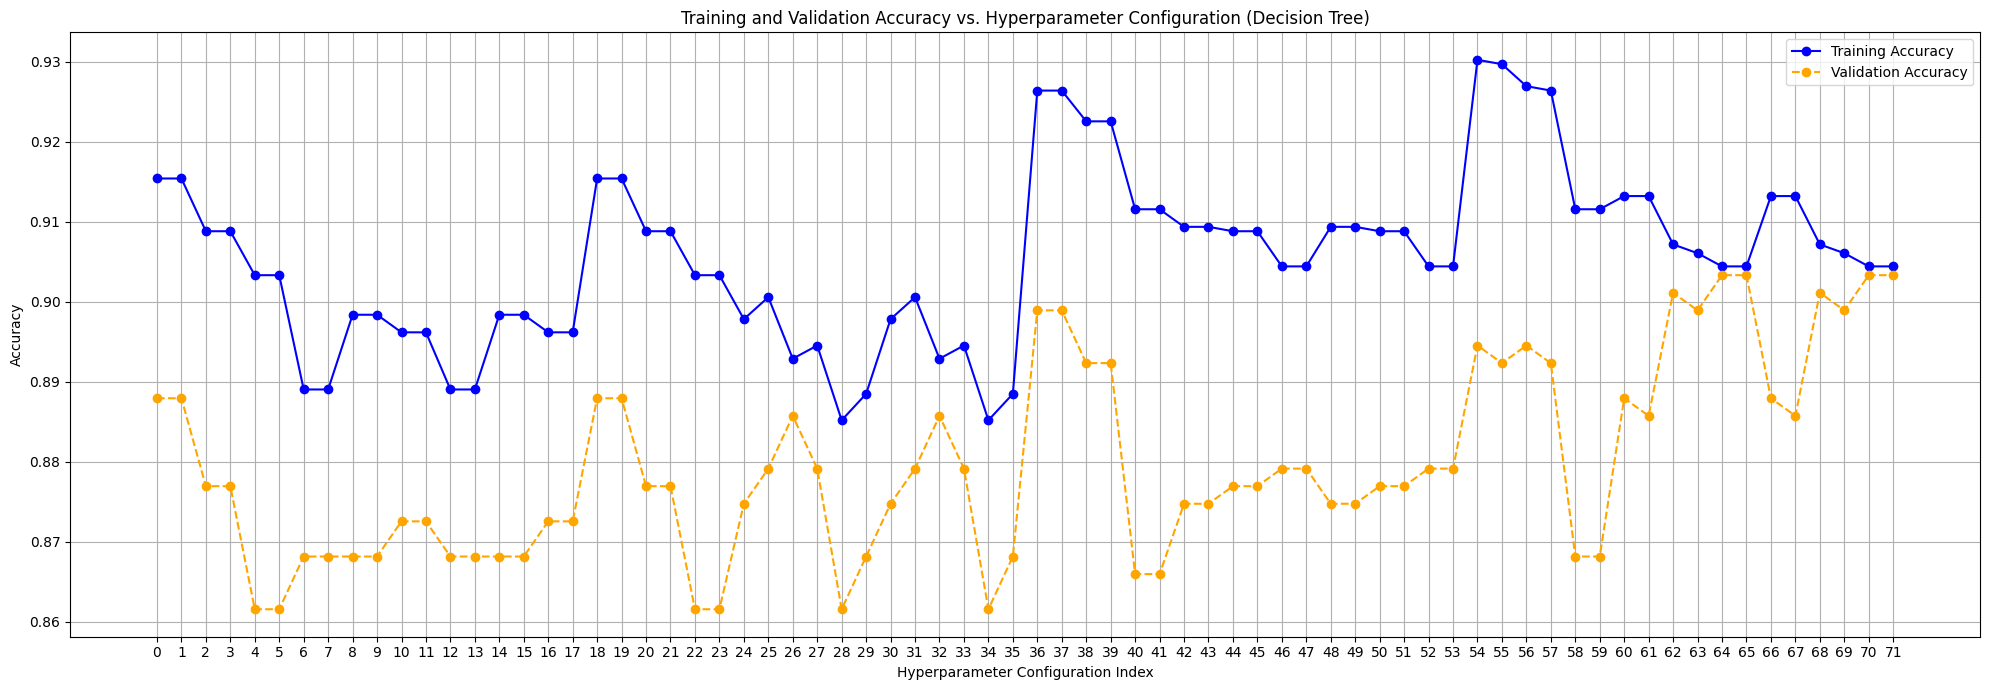


Configuration 0: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 30}
   Training Accuracy: 0.9154 		   Validation Accuracy: 0.8879

Configuration 1: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 35}
   Training Accuracy: 0.9154 		   Validation Accuracy: 0.8879

Configuration 2: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 30}
   Training Accuracy: 0.9088 		   Validation Accuracy: 0.8769

Configuration 3: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 35}
   Training Accuracy: 0.9088 		   Validation Accuracy: 0.8769

Configuration 4: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 30}
   Training Accuracy: 0.

In [111]:
plot_hyperparameter_results(dt_grid_search, "Decision Tree")

In [112]:
# Get the best model based on the grid search
best_dt_model = dt_grid_search.best_estimator_
dt_grid_search.best_params_

{'ccp_alpha': 0.02,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 30}

In [113]:
dt_grid_search.best_index_

64

### Training Evaluation

#### Grid search best model validation accuracy

In [114]:
# Get the index of the best configuration
best_config_index = dt_grid_search.best_index_
best_val_accuracy = dt_grid_search.cv_results_['mean_test_score'][best_config_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 90.33%


##### Cross-validation accuracy after grid search

In [115]:
# Perform cross-validation
scores = cross_val_score(best_dt_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.92307692 0.84615385 0.93406593 0.89010989 0.92307692]
Mean Accuracy: 0.9032967032967033


### Testing Evaluation


Tuned Decision Tree Performance:

Accuracy: 82.46%
Error Rate: 17.54%
Sensitivity (Recall): 66.67%
Specificity: 91.67%
Precision: 82.35%

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        72
           1       0.82      0.67      0.74        42

    accuracy                           0.82       114
   macro avg       0.82      0.79      0.80       114
weighted avg       0.82      0.82      0.82       114

Confusion Matrix:


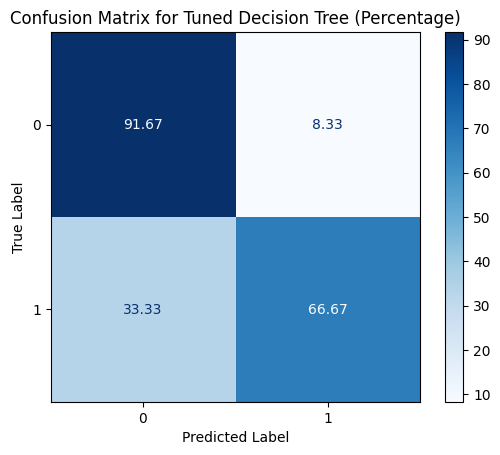

In [116]:
# Predict labels for the test set using the best Decision Tree model
y_test_pred_dt = best_dt_model.predict(X_test)
# Evaluate the model on the test set
report_test_dt = evaluate_model(y_test, y_test_pred_dt, "Tuned Decision Tree")

### Plot Decision Tree

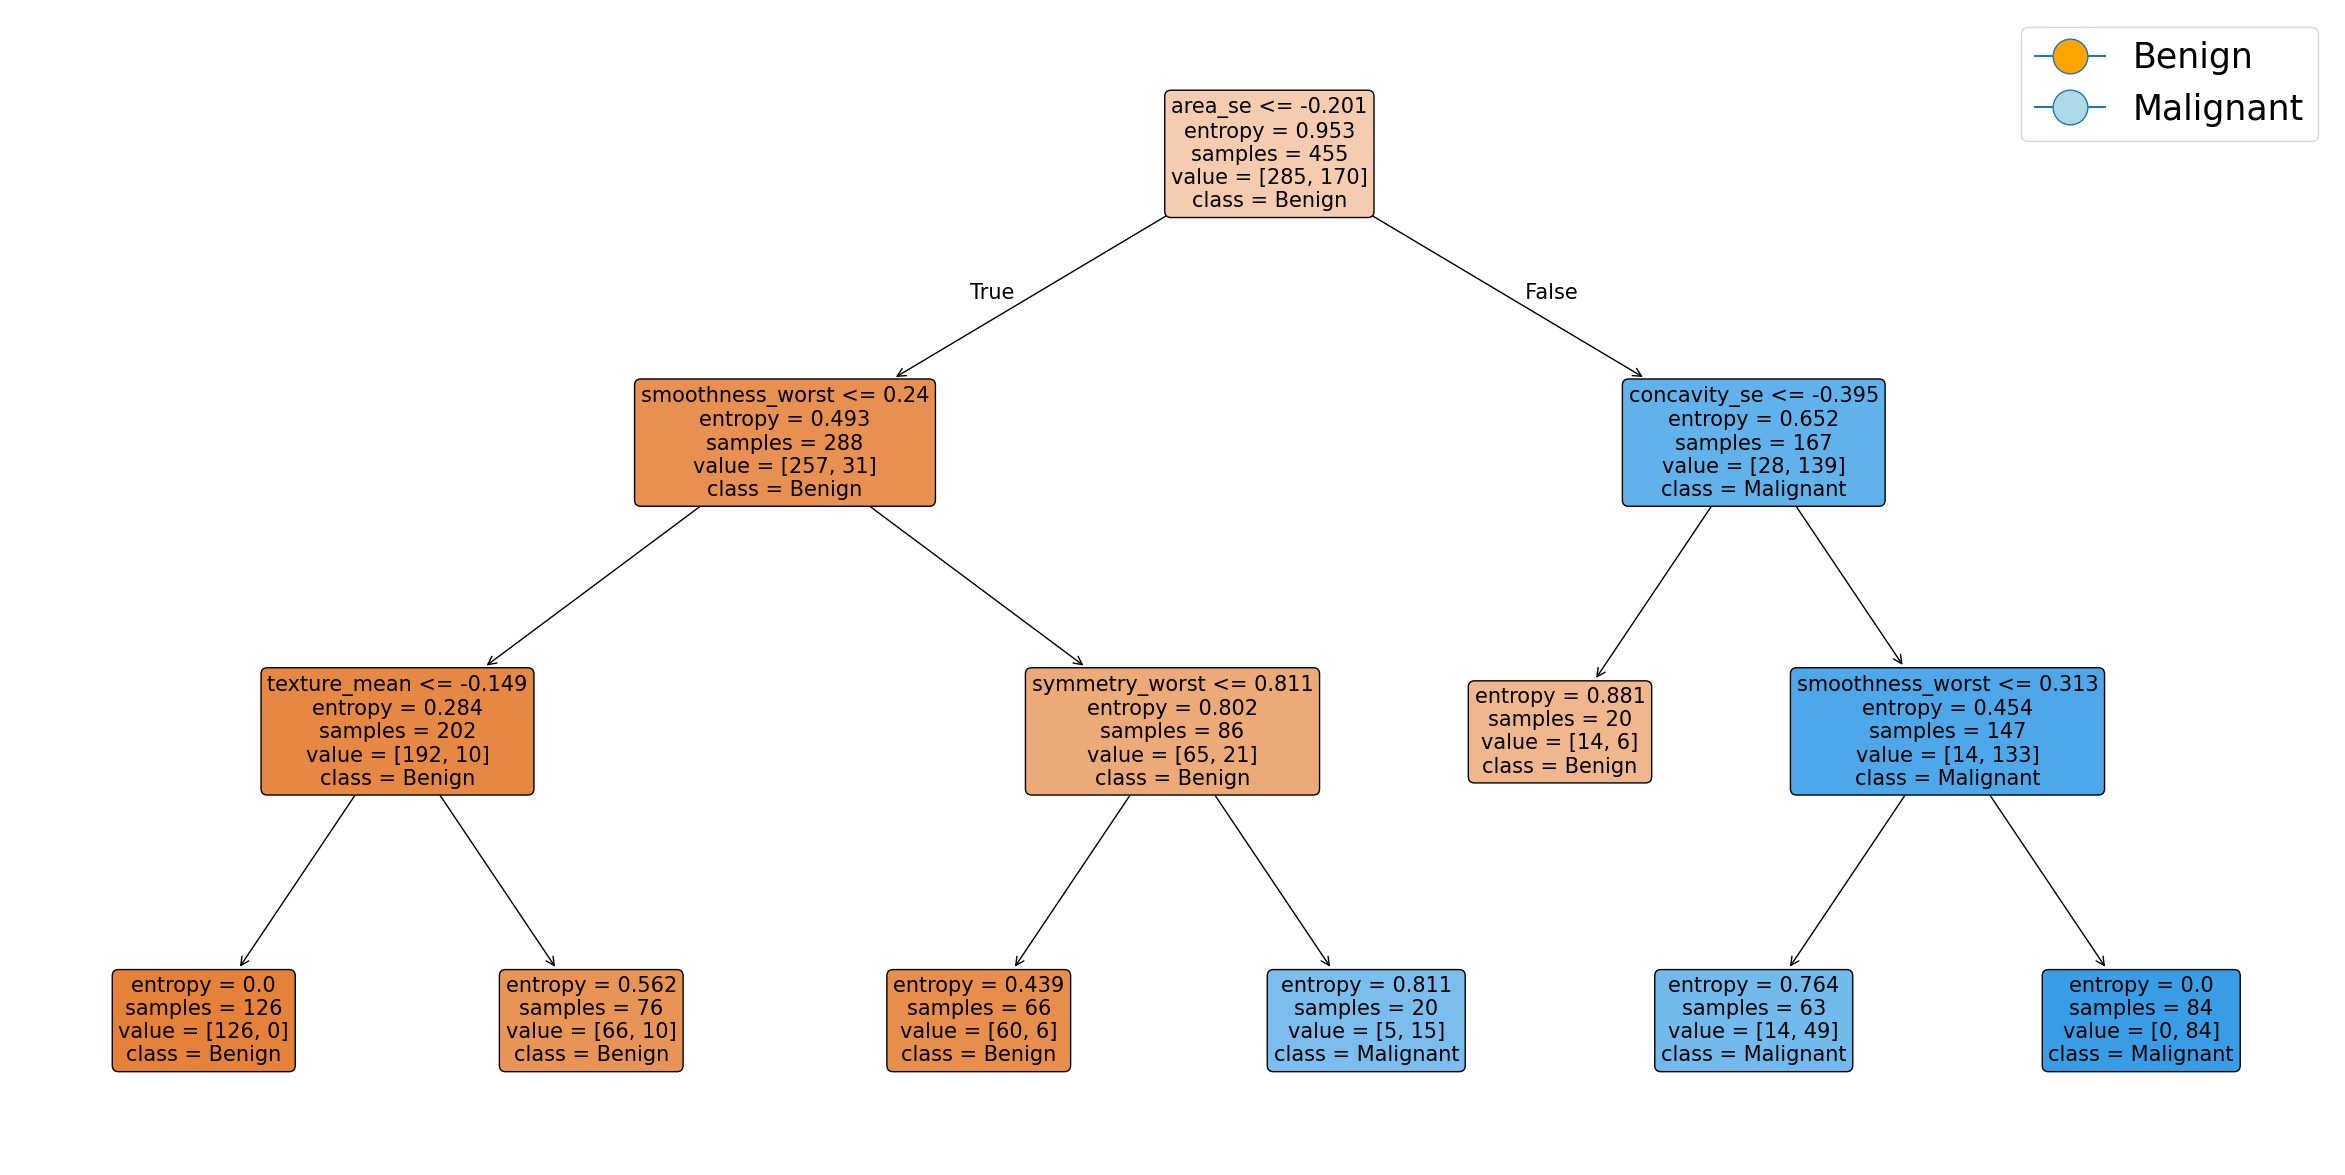

In [120]:
plt.figure(figsize=(30,15))
plot_tree(best_dt_model, filled=True, feature_names=X_train.columns, class_names=["Benign", "Malignant"], rounded=True, fontsize=15)

# Add a legend with colors for the classes
plt.legend(handles=[plt.Line2D([0], [0], marker='o', markerfacecolor=color, markersize=25) for color in ['orange', 'lightblue']], 
           labels=["Benign", "Malignant"], loc="best", fontsize=25)
plt.show()

## KNN Classifier

### Training

#### Intialize model

In [341]:
knn_model = KNeighborsClassifier(metric="euclidean")

#### Get best hyperparameters using grid search

In [336]:
# Hyperparameter grid for tuning the Decision Tree
knn_param_grid = {
    # List of possible values for the number of neighbors to consider during classification
    'n_neighbors': [3, 5, 9,  21],

    # List of distance metrics to use when calculating the distance between data points
    'metric': ['euclidean', 'minkowski']
}

In [337]:
# Set up GridSearchCV to search for the best hyperparameters
knn_grid_search = GridSearchCV(
    estimator=knn_model,                # KNN model
    param_grid=knn_param_grid,          # Hyperparameter grid to search
    scoring='f1_weighted',              # Use F1 weighted score as evaluation metric
    cv=5,                               # 5-fold cross-validation
    return_train_score=True             # Return training scores
)

#### Fit model with best hyperparameters

In [338]:
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski'],
                         'n_neighbors': [3, 5, 9, 21]},
             return_train_score=True, scoring='f1_weighted')

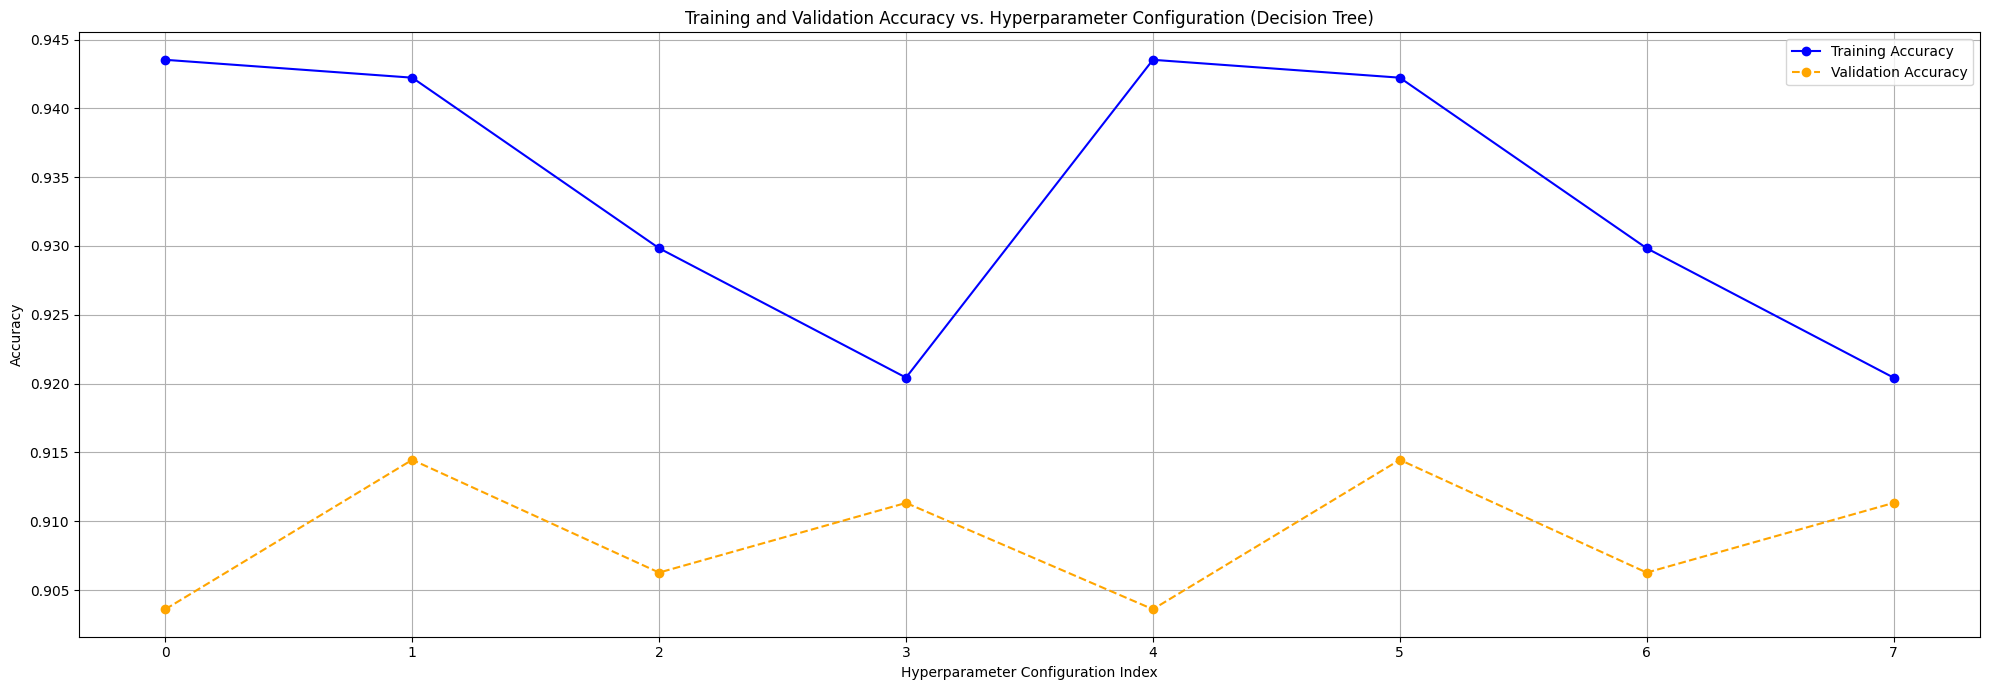


Configuration 0: {'metric': 'euclidean', 'n_neighbors': 3}
   Training Accuracy: 0.9435 		   Validation Accuracy: 0.9036

Configuration 1: {'metric': 'euclidean', 'n_neighbors': 5}
   Training Accuracy: 0.9422 		   Validation Accuracy: 0.9145

Configuration 2: {'metric': 'euclidean', 'n_neighbors': 9}
   Training Accuracy: 0.9298 		   Validation Accuracy: 0.9063

Configuration 3: {'metric': 'euclidean', 'n_neighbors': 21}
   Training Accuracy: 0.9204 		   Validation Accuracy: 0.9113

Configuration 4: {'metric': 'minkowski', 'n_neighbors': 3}
   Training Accuracy: 0.9435 		   Validation Accuracy: 0.9036

Configuration 5: {'metric': 'minkowski', 'n_neighbors': 5}
   Training Accuracy: 0.9422 		   Validation Accuracy: 0.9145

Configuration 6: {'metric': 'minkowski', 'n_neighbors': 9}
   Training Accuracy: 0.9298 		   Validation Accuracy: 0.9063

Configuration 7: {'metric': 'minkowski', 'n_neighbors': 21}
   Training Accuracy: 0.9204 		   Validation Accuracy: 0.9113


In [339]:
plot_hyperparameter_results(knn_grid_search, "Decision Tree")

In [330]:
best_knn_model = knn_grid_search.best_estimator_
knn_grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 5}

In [331]:
knn_grid_search.best_index_

1

#### Grid search best model validation accuracy

In [332]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

### Training Evaluation

In [333]:
# Get the index of the best configuration
best_config_index = knn_grid_search.best_index_
best_val_accuracy = knn_grid_search.cv_results_['mean_test_score'][best_config_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 91.45%


#### Cross-validation accuracy after grid search

In [334]:
# Perform cross-validation
scores = cross_val_score(best_knn_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.90410959 0.95890411 0.90410959 0.91780822 0.88888889]
Mean Accuracy: 0.9147640791476409


### Testing Evaluation


KNN Performance:

Accuracy: 88.60%
Error Rate: 11.40%
Sensitivity (Recall): 80.95%
Specificity: 93.06%
Precision: 87.18%

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        72
           1       0.87      0.81      0.84        42

    accuracy                           0.89       114
   macro avg       0.88      0.87      0.88       114
weighted avg       0.89      0.89      0.89       114

Confusion Matrix:


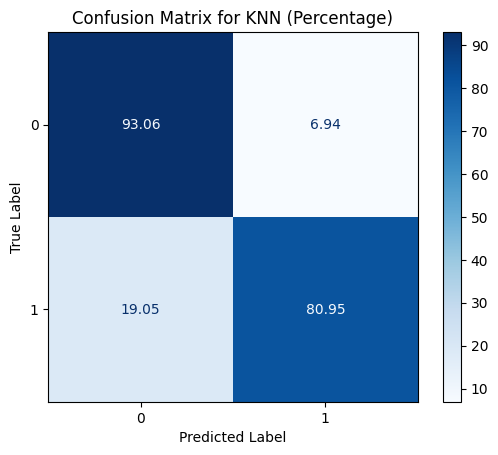

In [335]:
# Predict labels for the test set using the best KNN model
y_test_pred_knn = best_knn_model.predict(X_test)
# Evaluate the performance of the tuned KNN model on the test set
report_test_knn = evaluate_model(y_test, y_test_pred_knn, "KNN")

## Naïve Bayes Classifier

### Split data into Train, Validation, and Test Sets

In [215]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Split data into training (80%), testing (20%)

Then training into training (80%), validation (20%)

64% training - 16% validation - 20% testing

### Intialize model

In [216]:
nb_model = GaussianNB()

#### Fit model

In [217]:
nb_model.fit(X_train, y_train)

GaussianNB()

### Training Evaluation


Naive Bayes Performance:

Accuracy: 91.21%
Error Rate: 8.79%
Sensitivity (Recall): 90.91%
Specificity: 91.38%
Precision: 85.71%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        58
           1       0.86      0.91      0.88        33

    accuracy                           0.91        91
   macro avg       0.90      0.91      0.91        91
weighted avg       0.91      0.91      0.91        91

Confusion Matrix:


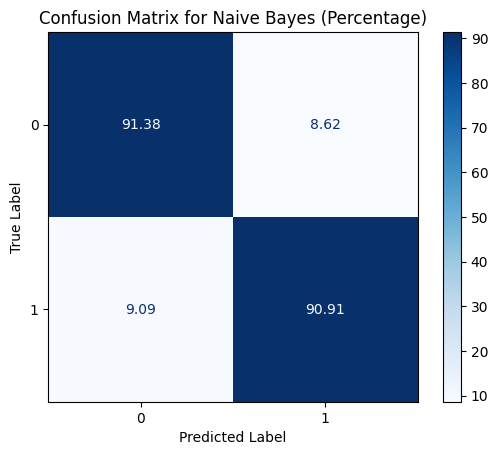

In [219]:
y_val_pred = nb_model.predict(X_val)
evaluate_model(y_val, y_val_pred, "Naïve Bayes")

### Testing Evaluation

#### Classification report


Naïve Bayes Performance:

Accuracy: 87.72%
Error Rate: 12.28%
Sensitivity (Recall): 83.33%
Specificity: 90.28%
Precision: 83.33%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        72
           1       0.83      0.83      0.83        42

    accuracy                           0.88       114
   macro avg       0.87      0.87      0.87       114
weighted avg       0.88      0.88      0.88       114

Confusion Matrix:


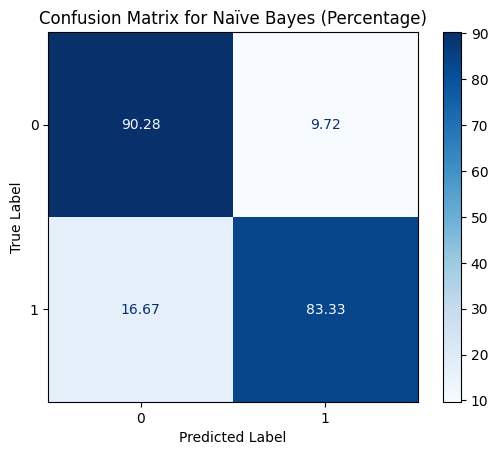

In [221]:
y_test_pred_nb = best_nb_model.predict(X_test)
evaluate_model(y_test, y_test_pred_nb, "Naïve Bayes")

## Multi‐Layer Perceptron

### Intialize model

In [152]:
mlp_model = MLPClassifier()

#### Get best hyperparameters using grid search

In [153]:
# Hyperparameter grid for tuning the Decision Tree
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # Different layer sizes
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimization algorithms
    'max_iter': [200, 500],  # Maximum iterations
    'learning_rate': ['constant', 'invscaling'],  # Learning rate schedules
}

In [154]:
# Set up GridSearchCV to tune hyperparameters with 5-fold cross-validation

mlp_grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=mlp_param_grid,
    scoring='f1_weighted',  # Evaluation metric
    cv=5,  # 5-fold cross-validation
    return_train_score=True,
    n_jobs=-1  # Parallelize the process if you have multiple CPU cores
)

#### Fit model to get best hyperparameters

In [155]:
mlp_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['constant', 'invscaling'],
                         'max_iter': [200, 500], 'solver': ['adam', 'sgd']},
             return_train_score=True, scoring='f1_weighted')

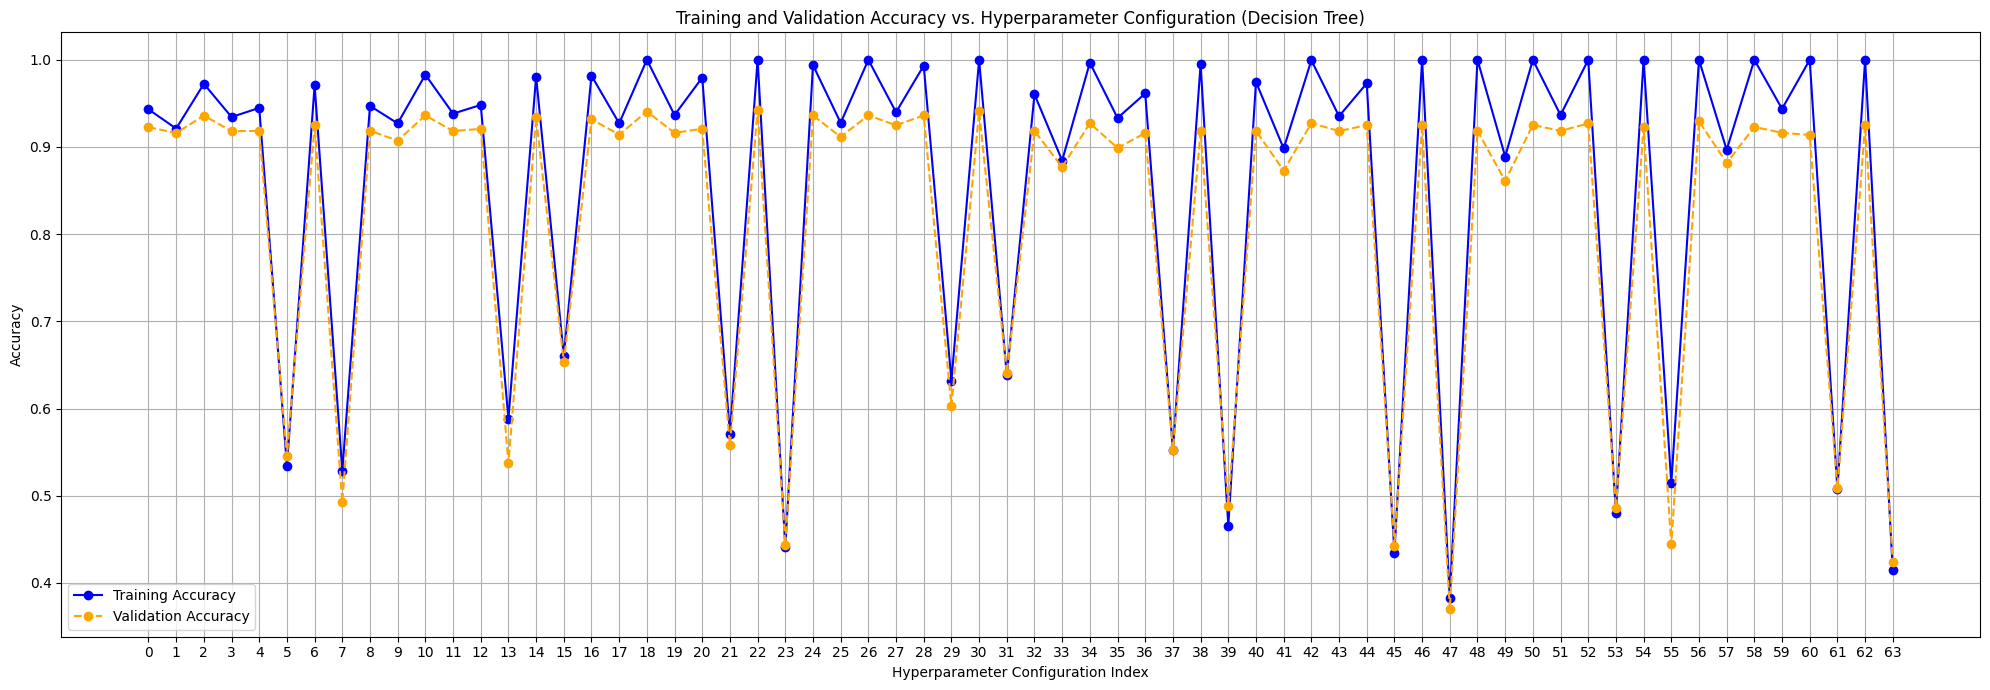


Configuration 0: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
   Training Accuracy: 0.9432 		   Validation Accuracy: 0.9228

Configuration 1: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'sgd'}
   Training Accuracy: 0.9211 		   Validation Accuracy: 0.9159

Configuration 2: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
   Training Accuracy: 0.9725 		   Validation Accuracy: 0.9360

Configuration 3: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'sgd'}
   Training Accuracy: 0.9344 		   Validation Accuracy: 0.9182

Configuration 4: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'adam'}
   Training Accuracy: 0.9448 		   Validation Accuracy: 0.9184

Configuration 5: {'

In [156]:
plot_hyperparameter_results(mlp_grid_search, "Decision Tree")

In [157]:
# Get the best model based on the grid search
best_mlp_model = mlp_grid_search.best_estimator_
mlp_grid_search.best_params_

{'activation': 'tanh',
 'hidden_layer_sizes': (50, 50),
 'learning_rate': 'invscaling',
 'max_iter': 500,
 'solver': 'adam'}

In [158]:
mlp_grid_search.best_index_

22

### Training Evaluation

#### Grid search best model validation accuracy

In [159]:
# Get the index of the best configuration
best_config_index = mlp_grid_search.best_index_
best_val_accuracy = mlp_grid_search.cv_results_['mean_test_score'][best_config_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 94.29%


#### Cross-validation accuracy after grid search

In [160]:
# Perform cross-validation
scores = cross_val_score(best_mlp_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.95604396 0.91208791 0.93406593 0.93406593 0.93406593]
Mean Accuracy: 0.9340659340659341


### Testing Evaluation

#### Classification Report

In [161]:
y_test_pred_dt = best_mlp_model.predict(X_test)
evaluate_model(y_test, y_test_pred_dt, "MLP")



MLP Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.97      0.86      0.91        42

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

Accuracy: 0.9385964912280702


#### Confusion Matrix

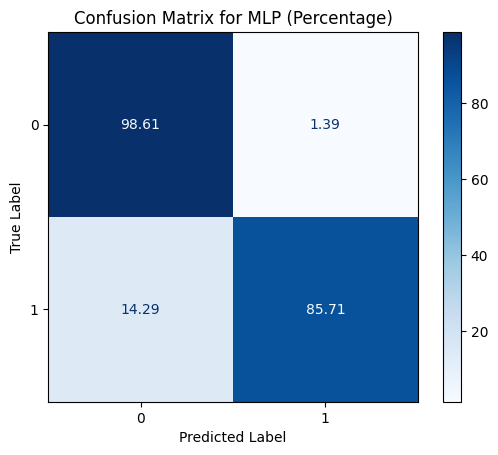

In [162]:
plot_confusion_matrix(y_test, y_test_pred_dt, "MLP")

## Models Comparisions

In [163]:
# Extract weighted average metrics
metrics = ["precision", "recall", "f1-score"]
x_labels = ["Precision", "Recall", "F1-Score"]

In [164]:
# To plot histogram
x = np.arange(len(metrics))
width = 0.15

### Validation Weighted Metrics

In [165]:
### Classification reports for validation
report_val_svm = classification_report(y_val, y_val_pred_svm, output_dict=True)
report_val_nb = classification_report(y_val, y_val_pred_nb, output_dict=True)
report_val_knn = classification_report(y_val, y_val_pred_knn, output_dict=True)
report_val_dt = classification_report(y_val, y_val_pred_dt, output_dict=True)

NameError: name 'y_val' is not defined

In [72]:
# Validation metrics
svm_val_metrics = [report_val_svm["weighted avg"][metric] for metric in metrics]
nb_val_metrics = [report_val_nb["weighted avg"][metric] for metric in metrics]
knn_val_metrics = [report_val_knn["weighted avg"][metric] for metric in metrics]
dt_val_metrics = [report_val_dt["weighted avg"][metric] for metric in metrics]

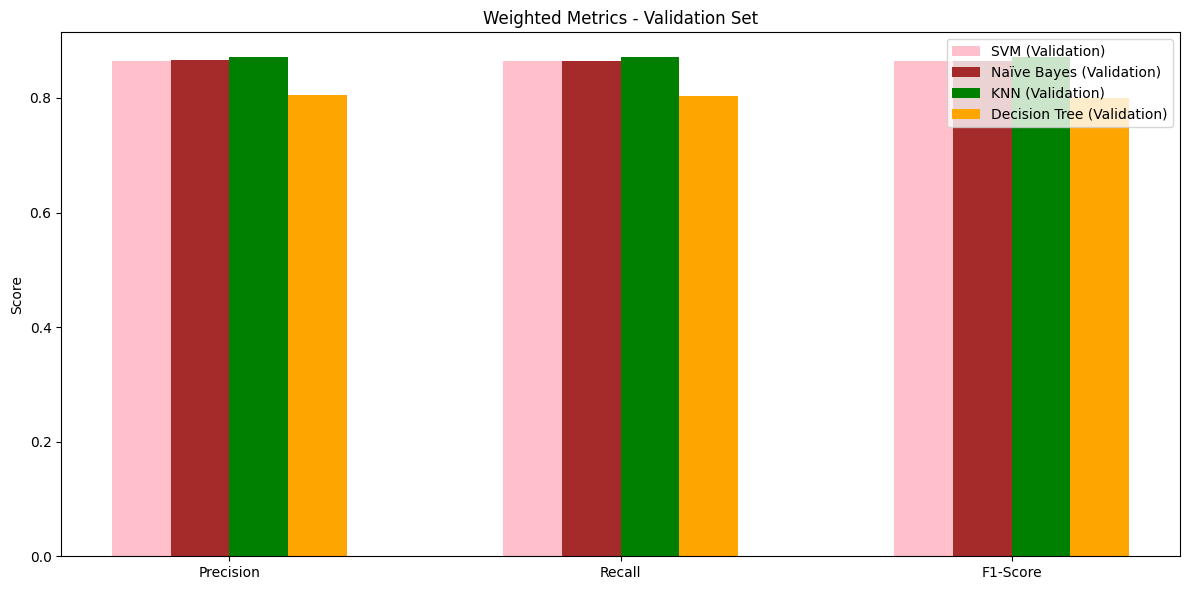

In [73]:
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, svm_val_metrics, width, label="SVM (Validation)", color='pink')
plt.bar(x - 0.5 * width, nb_val_metrics, width, label="Naïve Bayes (Validation)", color='brown')
plt.bar(x + 0.5 * width, knn_val_metrics, width, label="KNN (Validation)", color='green')
plt.bar(x + 1.5 * width, dt_val_metrics, width, label="Decision Tree (Validation)", color='orange')

plt.ylabel("Score")
plt.title("Weighted Metrics - Validation Set")
plt.xticks(x, x_labels)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Testing Weighted Metrics

In [74]:
# classification reports for testing
report_test_svm = classification_report(y_test, y_test_pred_svm, output_dict=True)
report_test_nb = classification_report(y_test, y_test_pred_nb, output_dict=True)
report_test_knn = classification_report(y_test, y_test_pred_knn, output_dict=True)
report_test_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)

In [75]:
# Testing metrics
svm_test_metrics = [report_test_svm["weighted avg"][metric] for metric in metrics]
nb_test_metrics = [report_test_nb["weighted avg"][metric] for metric in metrics]
knn_test_metrics = [report_test_knn["weighted avg"][metric] for metric in metrics]
dt_test_metrics = [report_test_dt["weighted avg"][metric] for metric in metrics]

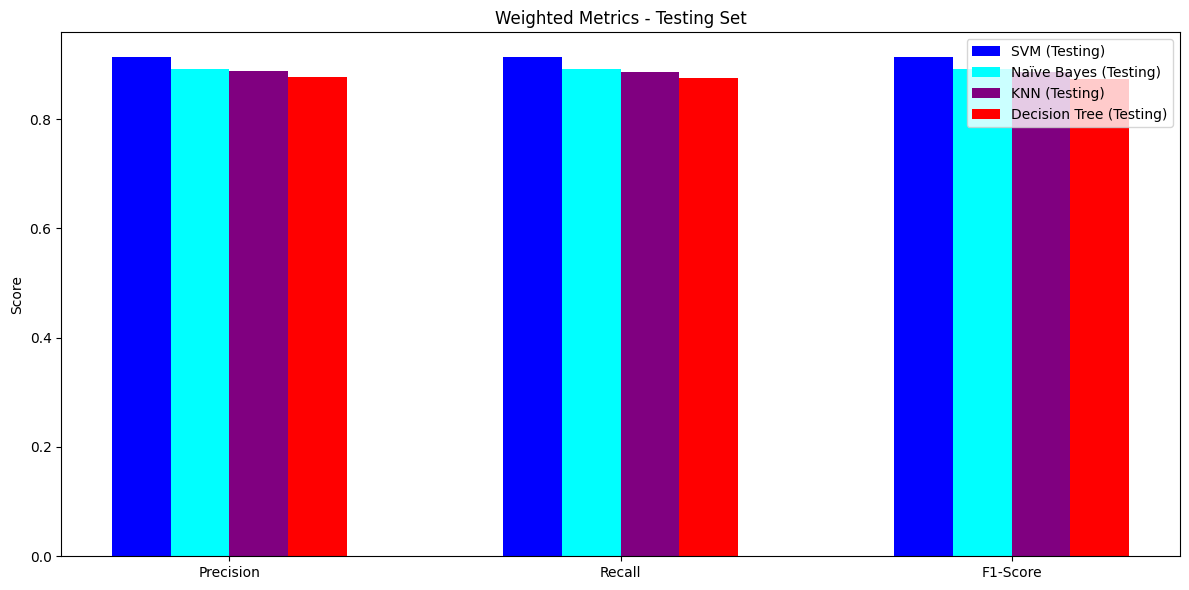

In [76]:
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * width, svm_test_metrics, width, label="SVM (Testing)", color='blue')
plt.bar(x - 0.5 * width, nb_test_metrics, width, label="Naïve Bayes (Testing)", color='cyan')
plt.bar(x + 0.5 * width, knn_test_metrics, width, label="KNN (Testing)", color='purple')
plt.bar(x + 1.5 * width, dt_test_metrics, width, label="Decision Tree (Testing)", color='red')

plt.ylabel("Score")
plt.title("Weighted Metrics - Testing Set")
plt.xticks(x, x_labels)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Dendogram

### Function to Plot Dendogram

In [77]:
def plot_dendrogram(X, method):
    # Compute the linkage matrix for hierarchical clustering
    linkage_matrix = linkage(X, method=method)

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Data Points or Clusters')
    plt.ylabel('Dissimilarity (Distance)')

    # Create the dendrogram plot with truncated visualization for simplicity
    dendrogram(
        linkage_matrix,
        truncate_mode='level',  # Limit the levels of hierarchy shown
        p=5,                    # Show top 5 levels
        leaf_rotation=90,       # Rotate leaf labels for better readability
        leaf_font_size=10,      # Font size for leaf labels
        show_contracted=True    # Contract large branches for readability
    )
    plt.show()
    
    return linkage_matrix

### Single linkage dendogram

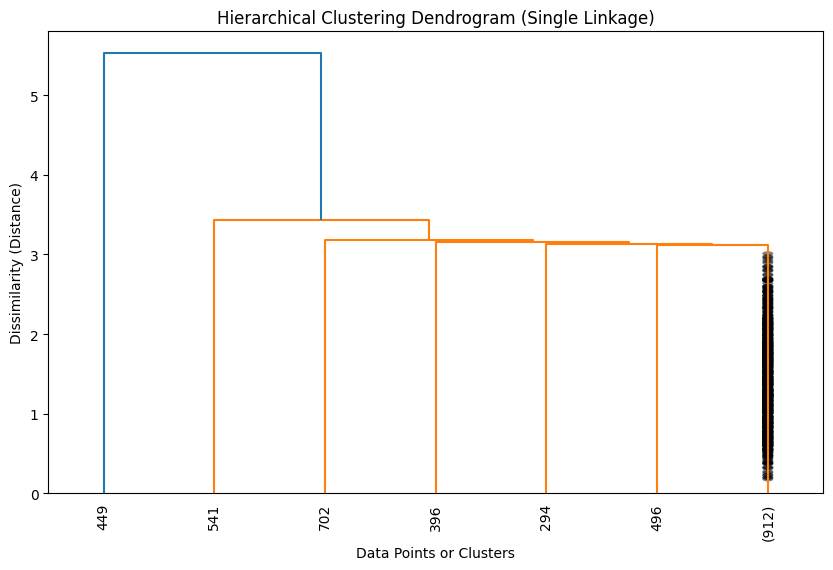

In [78]:
single_linkage = plot_dendrogram(X, 'single')

### Complete linkage dendogram

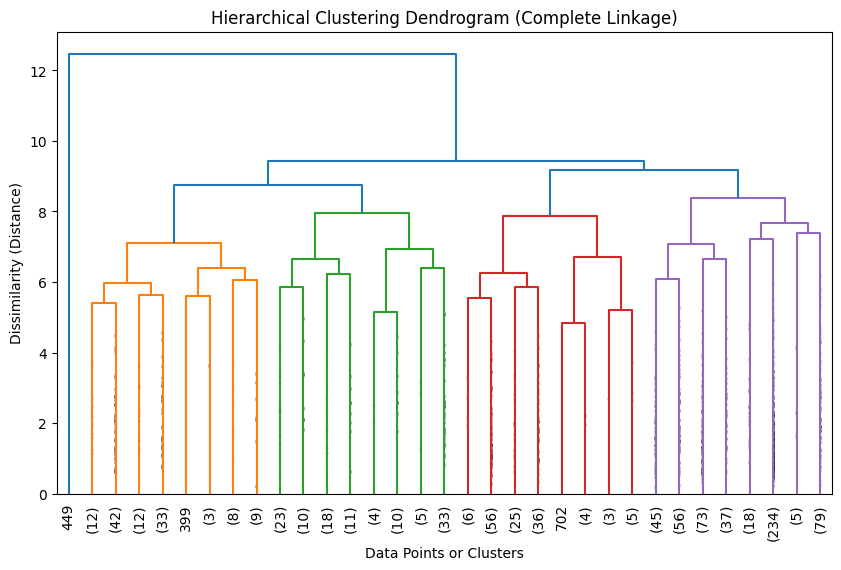

In [79]:
complete_linkage = plot_dendrogram(X, 'complete')

### Average linkage dendogram

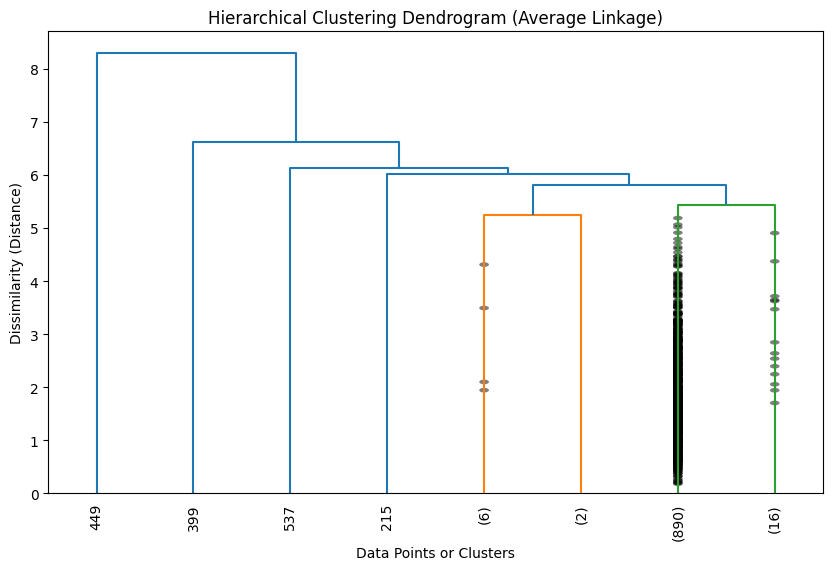

In [80]:
avg_linkage = plot_dendrogram(X, 'average')

### Centroid linkage dendogram

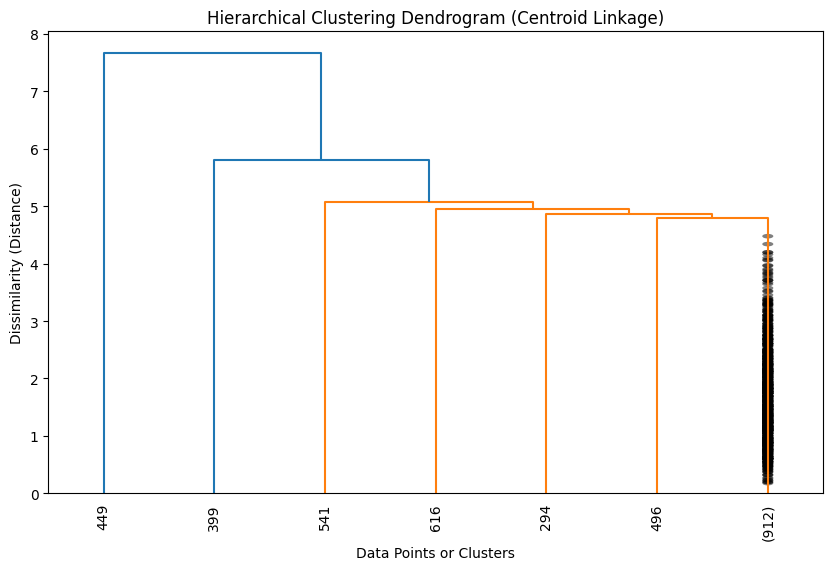

In [81]:
centroid_linkage = plot_dendrogram(X, 'centroid')

### Ward linkage dendogram

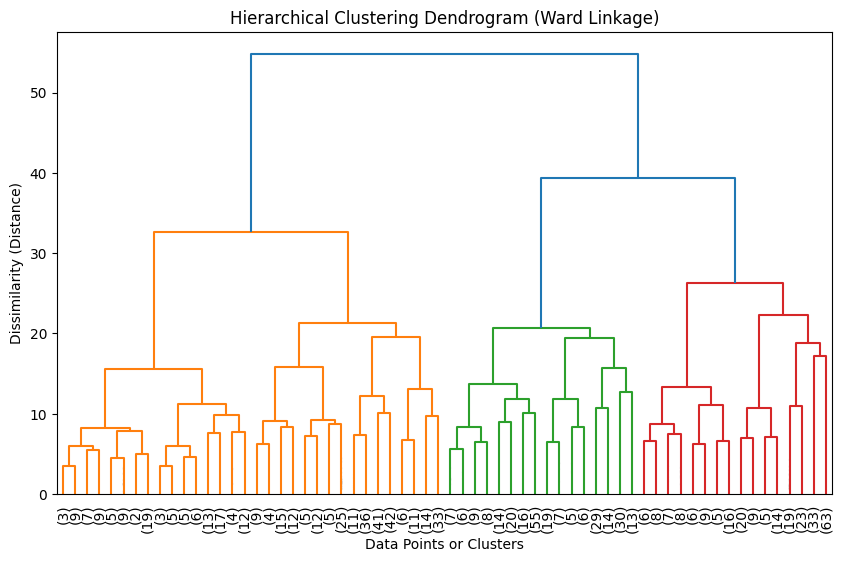

In [82]:
ward_linkage = plot_dendrogram(X, 'ward')

### Function to compare clusters with target column

In [83]:
# Add cluster labels and target labels to a DataFrame for comparison
def compare_clusters_with_target(cluster_labels):
    comparison_df = pd.DataFrame({
        'Cluster': cluster_labels,
        'Target': y
    })

    # Evaluate clustering performance
    # Count the number of data points in each cluster-target combination
    cluster_target_counts = comparison_df.groupby(['Cluster', 'Target']).size().unstack(fill_value=0)

    print("Cluster vs. Target Comparison:")
    print(cluster_target_counts)

    # Visualize the comparison
    cluster_target_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Cluster vs. Target Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title='Target')
    plt.show()

### Plot histogram to compare result clusters with target column

In [84]:
num_clusters = 2
# yes, no

#### Single Linkage

Cluster vs. Target Comparison:
Target     0    1
Cluster          
1        410  507
2          0    1


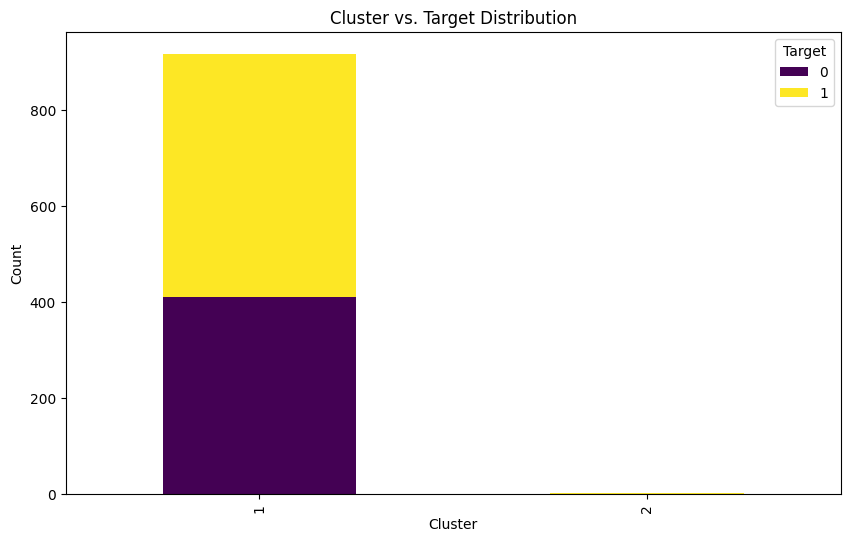

In [85]:
# Perform hierarchical clustering to get cluster labels using single linkage method
cluster_labels_Single = fcluster(single_linkage, num_clusters, criterion='maxclust')

# Compare the clusters with the actual target labels and visualize the distribution
compare_clusters_with_target(cluster_labels_Single)

#### Complete Linkage

Cluster vs. Target Comparison:
Target     0    1
Cluster          
1        410  507
2          0    1


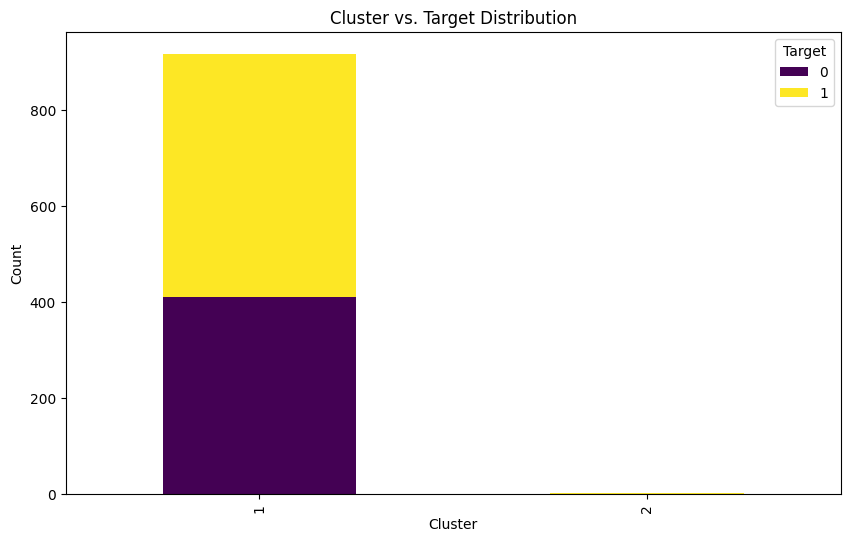

In [86]:
# Perform hierarchical clustering to get cluster labels using complete linkage method
cluster_labels_complete = fcluster(complete_linkage, num_clusters, criterion='maxclust')

# Compare the clusters with the actual target labels and visualize the distribution
compare_clusters_with_target(cluster_labels_complete)

#### Average Linkage

Cluster vs. Target Comparison:
Target     0    1
Cluster          
1        410  507
2          0    1


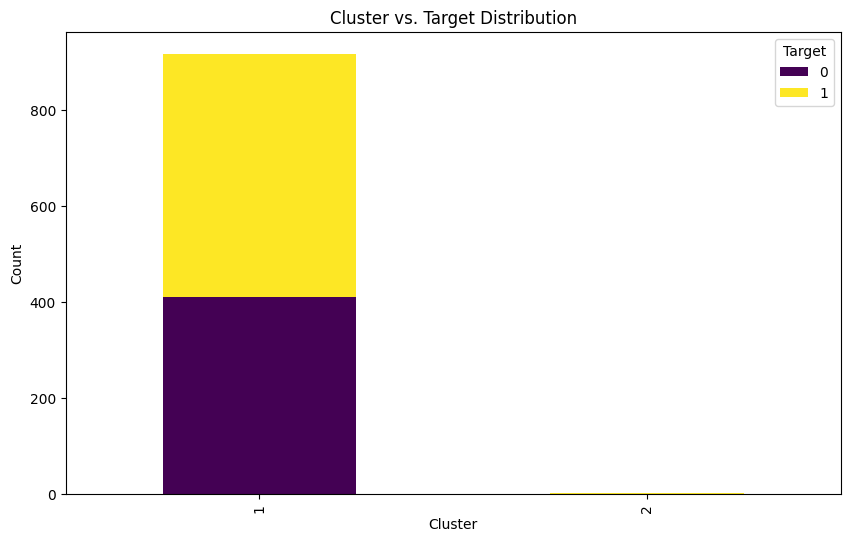

In [87]:
# Perform hierarchical clustering to get cluster labels using average linkage method
cluster_labels_average = fcluster(avg_linkage, num_clusters, criterion='maxclust')

# Compare the clusters with the actual target labels and visualize the distribution
compare_clusters_with_target(cluster_labels_average)

#### Centroid Linkage

Cluster vs. Target Comparison:
Target     0    1
Cluster          
1        410  507
2          0    1


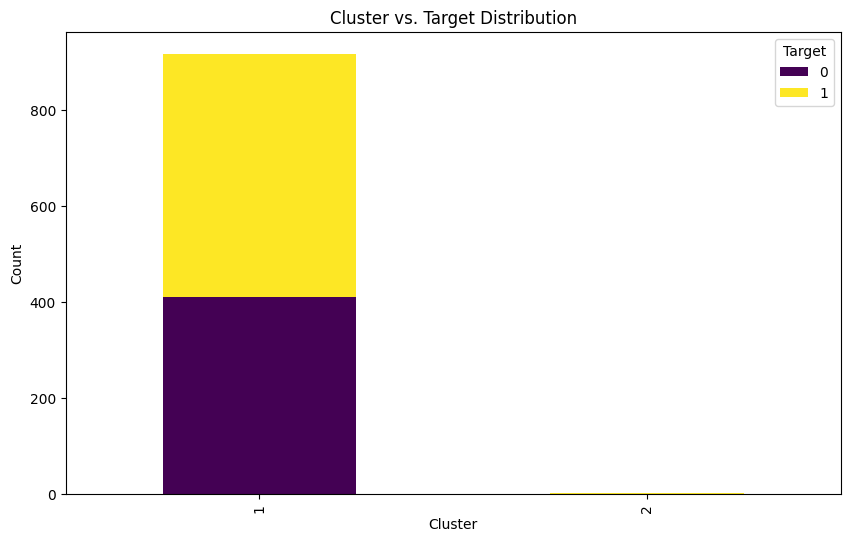

In [88]:
# Perform hierarchical clustering to get cluster labels using centroid linkage method
cluster_labels_centroid = fcluster(centroid_linkage, num_clusters, criterion='maxclust')

# Compare the clusters with the actual target labels and visualize the distribution
compare_clusters_with_target(cluster_labels_centroid)

#### Ward Linkage

Cluster vs. Target Comparison:
Target     0    1
Cluster          
1        307  102
2        103  406


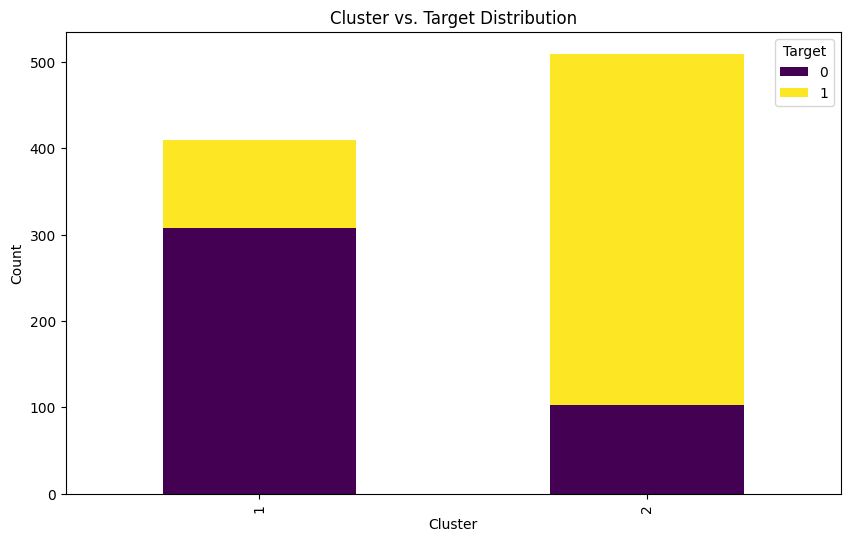

In [89]:
# Perform hierarchical clustering to get cluster labels using ward linkage method
cluster_labels_ward = fcluster(ward_linkage, num_clusters, criterion='maxclust')

# Compare the clusters with the actual target labels and visualize the distribution
compare_clusters_with_target(cluster_labels_ward)

**Looking at all linkages we found out their is an outlier index 449 that need to be removed.**